# Метод главных компонент #

> Данный ноутбук практически полностью основан на курсе лекций К.В. Воронцова [&laquo;Машинное обучение&raquo;](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%28%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%9A.%D0%92.%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D1%86%D0%BE%D0%B2%29), а именно на параграфе, посвящённом линейной регрессии.
Основным отличием от оригинала является код на Питоне, позволяющий ученику &laquo;поиграть&raquo; с методами и тем самым глубже разобраться в материале.

In [1]:
# Imports 
import sys
import warnings
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormaps
import seaborn as sns

sns.set_style('whitegrid')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Styles, fonts
sns.set_style('whitegrid')
matplotlib.rcParams['font.size'] = 13

---

## Генерация данных ##

In [3]:
def pol(a, x):
    return np.sum([a[i]*x**i for i in range(len(a))], axis=0)

def sin(a, x):
    return np.sin(a*x)

def xsin(a, x):
    return x*np.sin(a*x)

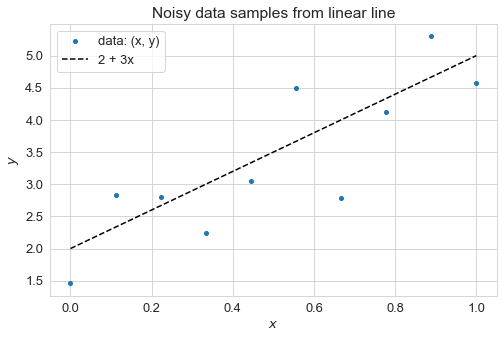

In [132]:
# Define the data
np.random.seed(123)
Ns = 10 # Number of samples
x_lim = np.array([0, 1])
# x_lim = np.array([-1, 1])

# Underlying functional relation
fun = pol
a = [2, 3]
label = f'{a[0]} + {a[1]}x'
# fun = sin
# a = 5
# label = f'sin({a}x)'

# Noise
e_std = 0.5  # Standard deviation of the noise
err = e_std * np.random.randn(Ns)  # Noise

# Features and output
# x = np.random.uniform(x_lim[0], x_lim[1], Ns)  # Independent variable x
x = np.linspace(x_lim[0], x_lim[1], Ns)  # Independent variable x
y = fun(a, x) + err  # Dependent variable

# Show data
X = np.linspace(x_lim[0], x_lim[1], 100)
plt.figure(figsize=(8, 5))
plt.title('Noisy data samples from linear line')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

In [133]:
# The number of fetures
Nf = 7
# Stack X with ones to be fitted by vectorized methods such as OLS and gradient descent
F = np.ones_like(x)
for i in range(1, Nf):
    F = np.vstack((F, x**i))
F = F.T
# print(F)

---

## Сингулярное разложение ##

Произвольную матрицу $F$ размерностью $l \times n$ ранга $n$ можно представить в виде сингулярного разложения (singular value decomposition, SVD)
$$ F = VDU^\top. $$

In [134]:
V, d, Ut = np.linalg.svd(F, full_matrices=False)
# print(V)
print(f'd = {d}')
# print(Ut.T)

mu = (d[0]/d[-1])**2
print(f'число обусловленности mu = {mu}')

d = [4.26767140e+00 1.85917337e+00 5.43195447e-01 1.23605815e-01
 2.17476574e-02 2.76075225e-03 2.10587414e-04]
число обусловленности mu = 410692831.954697


In [135]:
# Fit parameters with SVD
Alpha_svd = sum([1/d[i] * Ut[i] * (V.T[i] @ y) for i in range(Nf)])
print(Alpha_svd)

# Function representing fitted line
f_svd = lambda x: sum([Alpha_svd[i]*x**i for i in range(Nf)])

[ 1.41793792e+00  5.21470100e+01 -5.30090908e+02  2.14845113e+03
 -4.04419074e+03  3.56506849e+03 -1.18823356e+03]


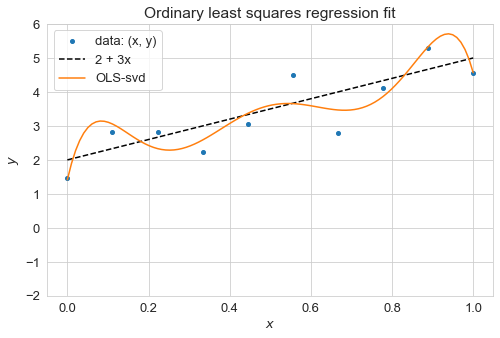

In [136]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
plt.title('Ordinary least squares regression fit')
plt.plot(x, y, 'o', ms=4, label='data: (x, y)')
plt.plot(X, fun(a, X), 'k--', label=label)
plt.plot(X, f_svd(X), '-', label='OLS-svd')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-2, 6)
plt.show()

---

## Метод главных компонент ##

В *методе главных компонент* (principal component analysis, PCA) строится минимальное число новых признаков, по которым исходные признаки восстанавливаются линейным преобразованием с минимальными погрешностями. PCA относится к методам *обучения без учителя* (unsupervised learning), поскольку матрица &laquo;объекты–признаки&raquo; $F$ преобразуется без учёта целевого вектора $y$.

Важно отметить, что PCA подходит и для регрессии, и для классификации, и для многих других типов задач анализа данных, как вспомогательное преобразование, позволяющее определить эффективную размерность исходных данных.

In [137]:
D = np.diag(d)
G = V @ D

In [35]:
def E(L, m):
    return sum(L[m:])/sum(L)

In [138]:
L = d**2
Em = np.empty(len(d))
for i in range(len(d)):
    Em[i] = E(L, i)

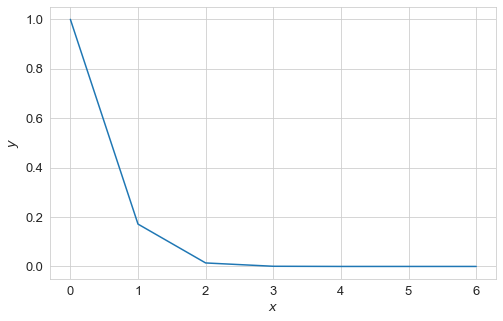

In [139]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
# plt.title('Title')
plt.plot(range(len(d)), Em, '-')
# plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
# plt.ylim(-2, 6)
plt.show()

In [140]:
N_pc = 2
norm = np.linalg.norm(G[:, :N_pc] @ Ut[:N_pc] - F)**2
norm_F = np.linalg.norm(F)**2
print(norm)
print(norm/norm_F)
print(Em[N_pc])

print(Ut[0])
print(Ut[1])

0.3108203175446414
0.014140816855900228
0.014140816855900238
[-0.67825205 -0.42822221 -0.3368154  -0.28564531 -0.25261473 -0.22946376
 -0.21235402]
[ 0.68036373 -0.09970988 -0.26258747 -0.31895654 -0.33988106 -0.34673772
 -0.3474644 ]


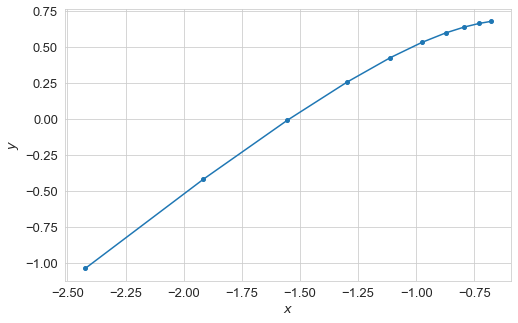

In [143]:
# Show OLS fitted line
plt.figure(figsize=(8, 5))
# plt.title('Title')
plt.plot(G.T[0], G.T[1], 'o-', ms=4)
# plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
# plt.xlim(0, 0.1)
plt.show()

### Проверка сингулярного разложения

In [10]:
A1 = np.dot(F, F.T)
w1, V1 = np.linalg.eig(A1)
ind = np.argsort(w1)[::-1]

for i, v in enumerate(V.T):
    print('SVD:')
    print('l = ', d[i]**2)
#     print('s = ', v)
#     print('Ax = ', np.dot(A1, v))
#     print('lx = ', d[i]**2 * v)
    
    j = ind[i]
    v1 = V1.T[j]
    print('EIG:')
    print('l = ', w1[j])
#     print('s = ', v1)
#     print('Ax = ', np.dot(A1, v1))
#     print('lx = ', w1[j]*v)
    print()

SVD:
l =  11.245817628216104
EIG:
l =  11.245817628216138

SVD:
l =  3.3769252285273623
EIG:
l =  3.3769252285273623

SVD:
l =  0.716242496612768
EIG:
l =  0.7162424966127684

SVD:
l =  0.12115555305632252
EIG:
l =  0.12115555305632235

SVD:
l =  0.018457240848328612
EIG:
l =  0.01845724084832886

SVD:
l =  0.0008087468295259861
EIG:
l =  0.0008087468295262425

SVD:
l =  2.470648377857478e-05
EIG:
l =  2.470648377838754e-05



In [12]:
A2 = np.dot(F.T, F)

# print(A1)
w1, V1 = np.linalg.eig(A1)
print(w1)
print(V1)
# print(np.linalg.matrix_rank(V1))
# print(np.linalg.det(V1))
# for v in v1:
#     print(np.linalg.norm(v))

# print(A2)
w2, V2 = np.linalg.eig(A2)
print(w2)
print(V2)
# print(np.linalg.matrix_rank(V2))

[ 1.12458176e+01  3.37692523e+00  7.16242497e-01  1.21155553e-01
  1.84572408e-02  8.08746830e-04  2.47064838e-05  3.48436377e-16
 -3.18556191e-16  5.93970116e-17]
[[ 0.28353903  0.10502771  0.31616176  0.0238433  -0.35038009 -0.23268053
  -0.20351227 -0.48246341  0.39196276 -0.03854746]
 [ 0.45082289 -0.60742043 -0.45539275  0.43244887 -0.17121741 -0.06169807
   0.01239696 -0.00674443 -0.01062273  0.00239292]
 [ 0.28965384  0.06652604  0.33662173 -0.08772963 -0.37638469 -0.50988461
   0.39370801  0.37351875 -0.16022173  0.00448032]
 [ 0.2707303   0.35832899 -0.1879978   0.1737534   0.56139155 -0.55488883
  -0.31980393  0.0115552  -0.07488475  0.0132751 ]
 [ 0.35705474 -0.24092743  0.15267764 -0.45552315  0.26134429  0.08153448
   0.10543936 -0.56288984 -0.57609086  0.14246325]
 [ 0.36085231 -0.25630595  0.13275165 -0.44234151  0.28159758  0.14621083
  -0.15342354  0.5349641   0.56660182 -0.13891115]
 [ 0.27399404  0.18504358  0.228554    0.22995139 -0.10163212  0.35223618
  -0.2940011

In [13]:
for i, v in enumerate(V1.T):
    print(np.dot(A1, v))
    print(w1[i]*v)

[3.18862823 5.06987197 3.25739422 3.04458356 4.01537251 4.0580793
 3.08128704 3.08105948 3.02971004 3.1559043 ]
[3.18862823 5.06987197 3.25739422 3.04458356 4.01537251 4.0580793
 3.08128704 3.08105948 3.02971004 3.1559043 ]
[ 0.35467073 -2.05121339  0.22465345  1.21005021 -0.81359391 -0.86552604
  0.62487835  0.62564599  0.90788876  1.5932443 ]
[ 0.35467073 -2.05121339  0.22465345  1.21005021 -0.81359391 -0.86552604
  0.62487835  0.62564599  0.90788876  1.5932443 ]
[ 0.22644849 -0.32617164  0.24110279 -0.13465201  0.10935422  0.09508237
  0.16370009  0.16345555  0.04713302 -0.44982083]
[ 0.22644849 -0.32617164  0.24110279 -0.13465201  0.10935422  0.09508237
  0.16370009  0.16345555  0.04713302 -0.44982083]
[ 0.00288875  0.05239358 -0.01062893  0.02105119 -0.05518916 -0.05359213
  0.02785989  0.02791642  0.03873834 -0.04893863]
[ 0.00288875  0.05239358 -0.01062893  0.02105119 -0.05518916 -0.05359213
  0.02785989  0.02791642  0.03873834 -0.04893863]
[-0.00646705 -0.0031602  -0.00694702  

In [14]:
# D = np.vstack([np.diag(d), np.zeros((N_obj-len(s), N_features))])
D = np.diag(d)
print(D)
# display(np.dot(np.dot(V, D), U.T) - F)

[[3.35347844 0.         0.         0.         0.         0.
  0.        ]
 [0.         1.83764121 0.         0.         0.         0.
  0.        ]
 [0.         0.         0.84631111 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.34807406 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.13585743 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.02843847
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.00497056]]


## Метод главных компонент ##

In [107]:
G = np.dot(V, D)
display(G)
L = np.dot(G.T, G)
display(L)
display(L.diagonal())

array([[-0.53259741,  0.30490545,  0.31460882,  0.17495239],
       [-1.03557852, -0.10497457,  0.29855246, -0.17708409],
       [-0.92191585,  0.41149424, -0.30727702, -0.06100885],
       [-1.16374257, -0.37211451, -0.16623161,  0.12584425]])

array([[ 3.56030846e+00,  5.55111512e-17,  1.66533454e-16,
        -2.77555756e-17],
       [ 5.55111512e-17,  4.11783713e-01,  1.59594560e-16,
         6.93889390e-18],
       [ 1.66533454e-16,  1.59594560e-16,  3.10164396e-01,
        -1.38777878e-17],
       [-2.77555756e-17,  6.93889390e-18, -1.38777878e-17,
         8.15259712e-02]])

array([3.56030846, 0.41178371, 0.3101644 , 0.08152597])

## Литература ##

1. Воронцов К.В. [Математические методы обучения по прецендентам (теория обучения машин)](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf). 141 c.

In [122]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
# print('scipy: {}'.format(sp.__version__))

Python: 3.7.6
numpy: 1.18.1
matplotlib: 3.1.3
seaborn: 0.10.0


In [3]:
def draw_xy(plt, xy, ci):
    plt.plot([0, xy[0, 0]], [0, xy[1, 0]], c=cm.tab10(ci)) 
    plt.plot([0, xy[0, 1]], [0, xy[1, 1]], c=cm.tab10(ci)) 

In [11]:
from numpy import sin, cos
a = np.pi/4
b = np.pi/3

u1 = np.array([cos(b), sin(b)], ndmin=2).T
u2 = np.array([-sin(b), cos(b)], ndmin=2).T
U = np.hstack([u1, u2])
# U = V
print(U)

S = np.diag([2, 1])

v1 = np.array([cos(a), sin(a)], ndmin=2).T
v2 = np.array([-sin(a), cos(a)], ndmin=2).T
V = np.hstack([v1, v2])
print(V.T)
print()
M = U @ S @ V.T
print(M)

[[ 0.5       -0.8660254]
 [ 0.8660254  0.5      ]]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]

[[1.31947922 0.09473435]
 [0.87119148 1.57829826]]


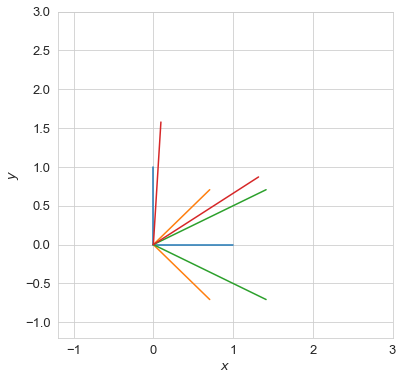

In [12]:
x = np.array([1, 0], ndmin=2).T
y = np.array([0, 1], ndmin=2).T
xy = np.hstack([x, y])

xy1 = V.T@ xy
xy2 = S @ xy1
xy3 = U @ xy2

# Show decomposition step by step
plt.figure(figsize=(6, 6))
# plt.title('Title')
draw_xy(plt, xy, 0)
draw_xy(plt, xy1, 1)
draw_xy(plt, xy2, 2)
draw_xy(plt, xy3, 3)
# plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(-1.2, 3)
plt.ylim(-1.2, 3)
plt.show()

In [6]:
# u, s, vh = np.linalg.svd(M)
# print(f'{u}\n {s}\n {vh}\n')

w, v = np.linalg.eig(M)
print(f'{w}\n {v}\n')

M2 = v @ np.diag(w) @ np.linalg.inv(v)
print(M2)

[7.21110547 2.21879989]
 [[ 0.94868302  0.78935205]
 [-0.3162286   0.61394083]]

[[ 5.71341131 -4.49306933]
 [-1.16487389  3.71649405]]


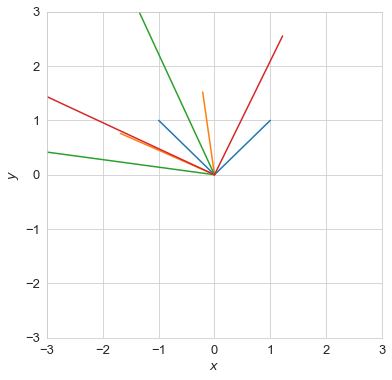

In [7]:
x = np.array([1, 1]).T
y = np.array([-1, 1]).T

xy1 = np.linalg.inv(v)@xy
xy2 = np.diag(w) @ xy1
xy3 = v @ xy2

# Show decomposition step by step
plt.figure(figsize=(6, 6))
# plt.title('Title')
draw_xy(plt, xy, 0)
draw_xy(plt, xy1, 1)
draw_xy(plt, xy2, 2)
draw_xy(plt, xy3, 3)
# plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()